# XGBoost feature score and shapely values

In [1]:
lib = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy'
import sys
sys.path.append(lib)
from utilities.package_importing import *
import scipy.stats as stats
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
import xgboost as xgb
from utilities.smart_seq_dataset import *
from utilities.smart_seq_dataset import *
import shap 


### Dataset

In [2]:
pickle_path = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\python_playground\classifying-response-to-immunotherapy\XGBoost_facilities\data\smartseq_data_4k_genes.p'
split_data_path = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\python_playground\classifying-response-to-immunotherapy\XGBoost_facilities\original_files\patients_divisions\all_test0.1_ver1.p'


In [3]:
cells, gene_names, patients_information = pickle.load(open(pickle_path, "rb"))
rna_seq_dataset = RNAseq_Dataset(cells, patients_information, gene_names)
print(rna_seq_dataset.cells.shape)

(16291, 4141)


#### Keep only activated T cells:

In [4]:

supervised_classification = r'Activated T cells'
rna_seq_dataset = rna_seq_dataset.filter_cells_by_supervised_classification(supervised_classification)
print(rna_seq_dataset.cells.shape)

(5007, 4141)


In [5]:
train_y = np.array([p.response_label for p in rna_seq_dataset.cells_information_list])
train_x = xgb.DMatrix(rna_seq_dataset.cells, label=train_y, feature_names=rna_seq_dataset.gene_names)

###  option (1) build new XGBoost

In [327]:
# num_round = 10
# params = {'max_depth': 20,
#            'eta': 1,
#            'objective': 'binary:logistic',
#            'nthread': 4,
#            'eval_metric': 'auc'}

num_round = 5
max_depth = 5
params = {'max_depth': max_depth,
           'eta': 1,
           'objective': 'binary:logistic',
           'nthread': 4,
           'eval_metric': 'auc'}



xgb_model = xgb.train(params, train_x, num_round, verbose_eval=True)

In [328]:
# Save model

FOLDER_XGBOOST = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\python_playground\classifying-response-to-immunotherapy\XGBoost_facilities\models'
XGBOOST_FILE_NAME = fr'activated_t_cells_round_{num_round}_depth_{max_depth}.pkl'


pickle.dump(xgb_model, open(join(FOLDER_XGBOOST, XGBOOST_FILE_NAME), "wb"))

### option (2) Load existing XGBoost

In [6]:
FOLDER_XGBOOST = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\python_playground\classifying-response-to-immunotherapy\XGBoost_facilities\models'
XGBOOST_FILE_NAME = r'activated_t_cells_round_5_depth_5.pkl'
# XGBOOST_FILE_NAME = r'activated_t_cells_round_10_depth_20.pkl'

xgb_model = pickle.load(open(join(FOLDER_XGBOOST, XGBOOST_FILE_NAME), "rb"))

### Check overfitting: 

In [7]:
predictions = xgb_model.predict(train_x)

bool_results = np.equal((train_y==1), predictions>0.5)
print(f'should be 1.0:  {sum(bool_results)/len(bool_results)}')

def make_prediction(val):
    return 'Responder' if val>0.5 else 'Non-responder'

res = sum([(cy.response!=make_prediction(cp)) for cy, cp in zip(rna_seq_dataset.cells_information_list, predictions)])

print(f'should be True:  {res==0}')

should be 1.0:  0.8585979628520072
should be True:  False


# Print Tree

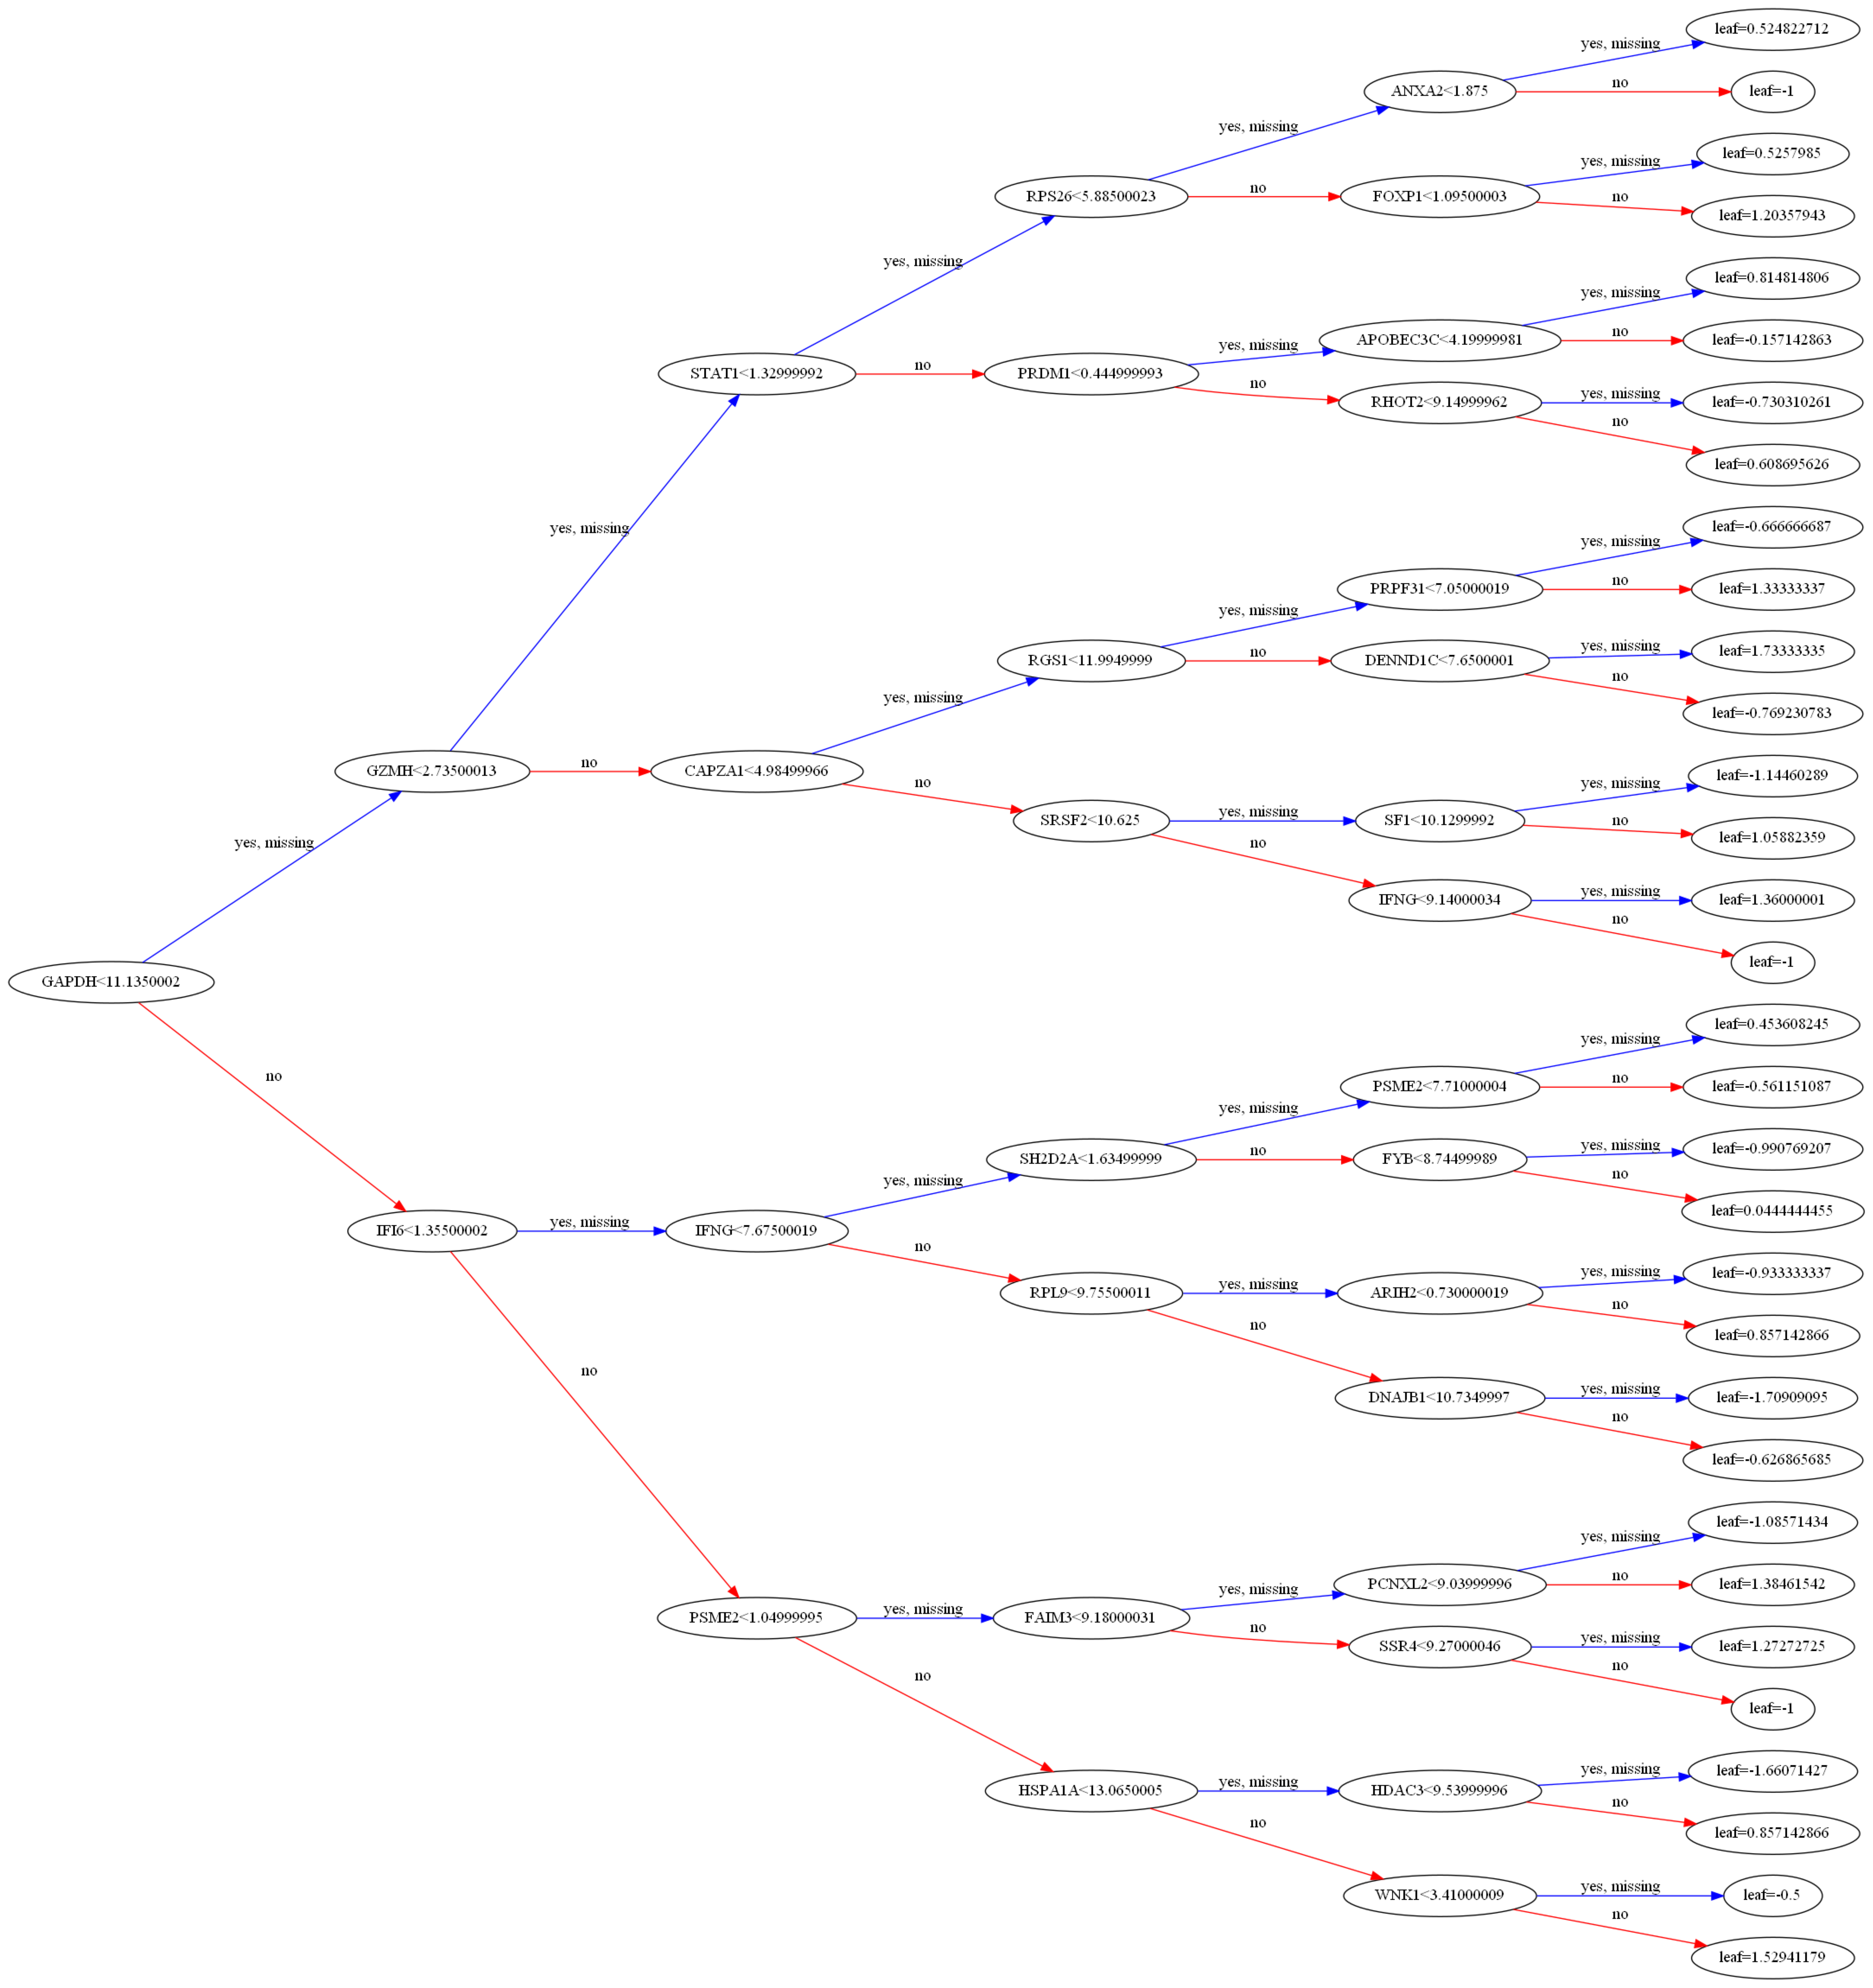

In [449]:
VISUALIZATION_OUTPUT = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\python_playground\classifying-response-to-immunotherapy\XGBoost_facilities\visualization'

# plot_tree(xgb_model, num_trees=0)#, rankdir='LR');

fig, ax = plt.subplots(figsize=(120, 60))
plot_tree(xgb_model, ax=ax, num_trees=0, rankdir='LR');
fig.savefig(join(VISUALIZATION_OUTPUT, 'tree.jpg'))

# Feature importance

In [424]:
method_score = 'gain' # 'cover'
feature_score_df = pd.DataFrame(list(xgb_model.get_score(importance_type=method_score).items()), columns=['Gene', 'Feature importance score'])


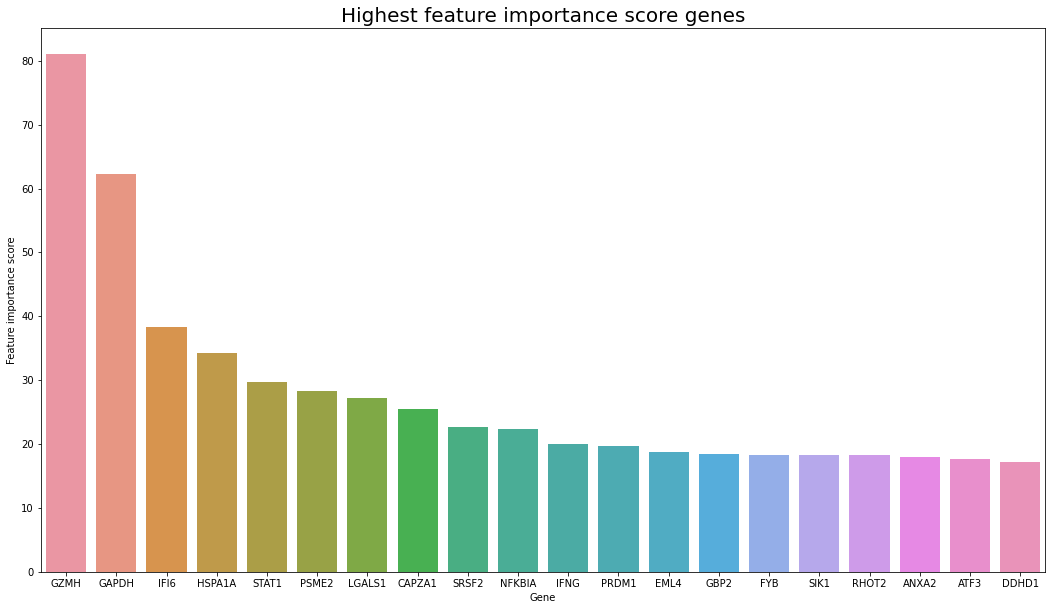

In [425]:
plt.figure(figsize=(18, 10))

g = sns.barplot(x='Gene', y='Feature importance score', 
                data=feature_score_df.sort_values('Feature importance score', ascending=False).iloc[:20])
g.set_title(label='Highest feature importance score genes', fontsize = 20);

# Shapley

In [8]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(train_x)

In [9]:
feature_order = np.argsort(np.abs(shap_values).mean(axis=0))[::-1]
features_sorted_by_shapely_value = list(np.array(gene_names)[feature_order])
mean_shap_values_sorted = np.abs(shap_values).mean(axis=0)[feature_order]

### 20 genes with the highest shapely score 

In [12]:
shapely_score_df = pd.DataFrame(np.array([features_sorted_by_shapely_value,
                                 mean_shap_values_sorted]).T, 
                                columns=['Gene', 'Shapely score'])
shapely_score_df['Shapely score'] = shapely_score_df['Shapely score'].astype(float)

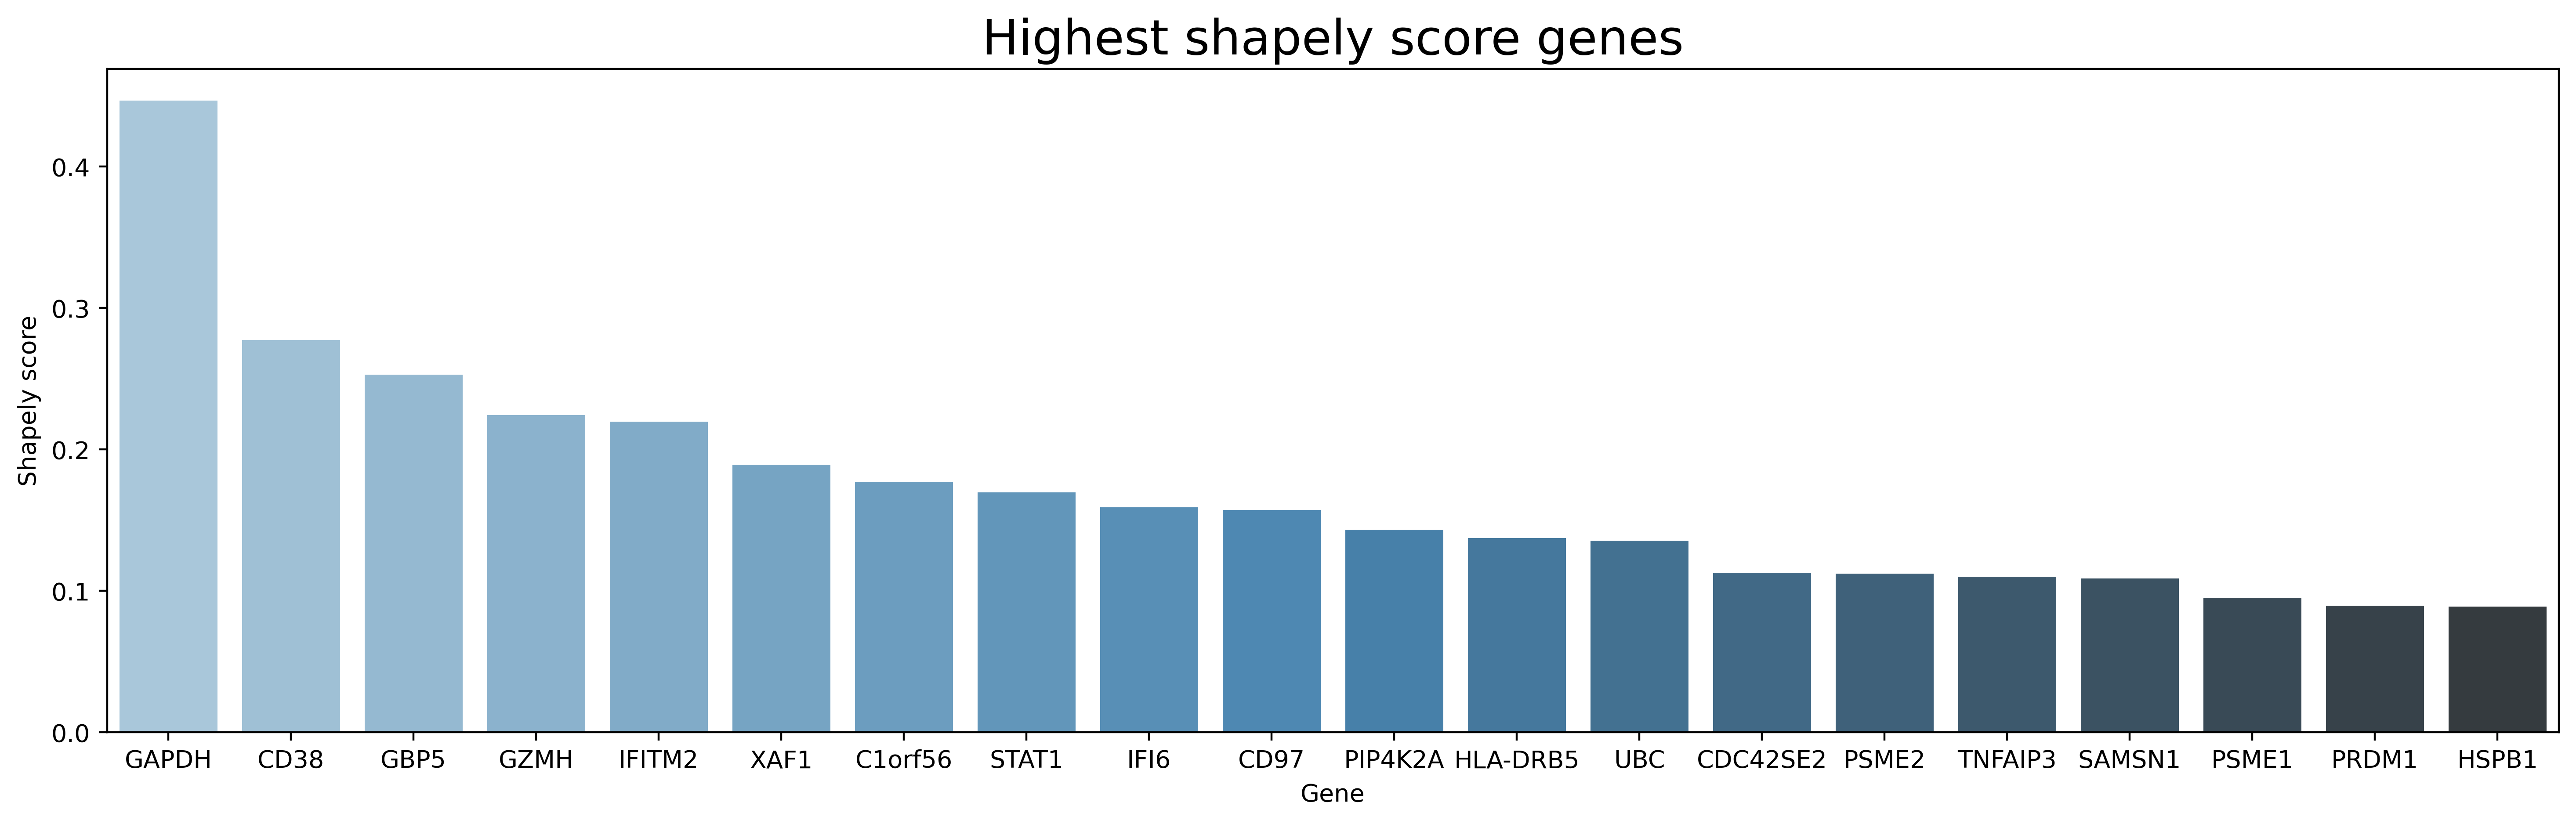

In [17]:
top_k = 20

# plt.figure(figsize=(18, 10))
plt.figure(figsize=(18, 5))

g = sns.barplot(x='Gene', y='Shapely score', palette="Blues_d",
                data=shapely_score_df.iloc[:top_k])
g.set_title(label='Highest shapely score genes', fontsize = 20);

In [19]:
output_path =  r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\python_playground\outputs\XGBoost'
jpg_name = 'shapely_top_20_v2.jpg'
excel_name = 'shapely_top_20.xlsx'

g.get_figure().savefig(join(output_path, jpg_name))
shapely_score_df.to_excel(join(output_path, excel_name))

# VIsualizations

In [413]:
VISUALIZATION_OUTPUT = r'C:\Users\KerenYlab\Desktop\Technion studies\Keren laboratory\python_playground\classifying-response-to-immunotherapy\XGBoost_facilities\visualization'

In [437]:
# i= 300
i = 2000

print(f'Label: {rna_seq_dataset.cells_information_list[i].response}')
print(f"prediction: {'R' if predictions[i]>0.5 else 'NR'}")
shap.force_plot(explainer.expected_value, shap_values[i], features=rna_seq_dataset.cells[i], feature_names=gene_names)

Label: Non-responder
prediction: R


In [438]:
# fig = shap.force_plot(explainer.expected_value, shap_values[i], features=rna_seq_dataset.cells[i], feature_names=gene_names).matplotlib(figsize=(16,3), show= True, text_rotation='horizontal')
# fig.savefig(join(VISUALIZATION_OUTPUT, f'one_sample_shapley_{i}.jpg'), bbox_inches = "tight")

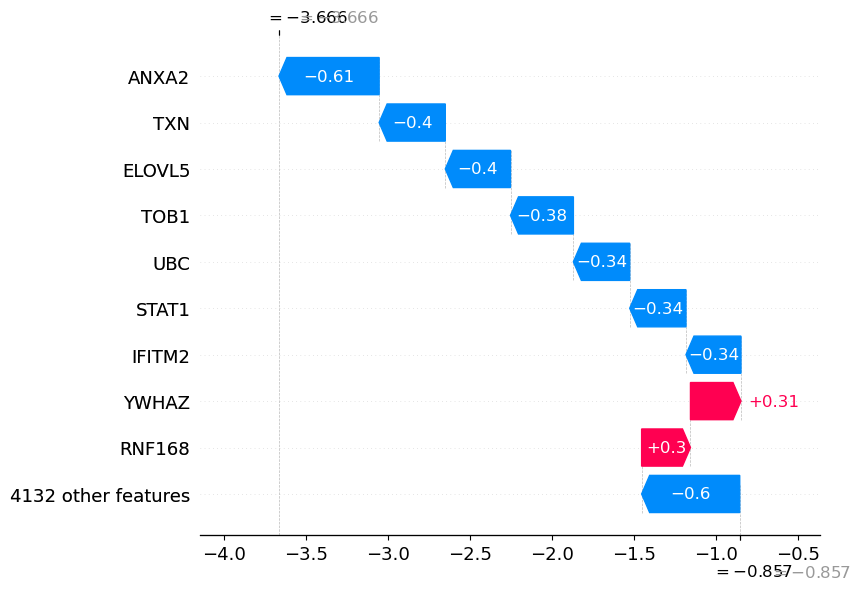

In [440]:
# plt.rcdefaults()  # reset params
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[i], feature_names=gene_names)
# plt.savefig(join(VISUALIZATION_OUTPUT, f'one_sample_shapley_v2_{i}.jpg'), bbox_inches = "tight")

In [430]:
gene_name = 'GAPDH'

print(f'Gene expression: {rna_seq_dataset.cells[i, gene_names.index(gene_name)]}')
print(f'Gene Shapely val: {shap_values[i, gene_names.index(gene_name)]}')

Gene expression: 13.27
Gene Shapely val: -0.42638397216796875


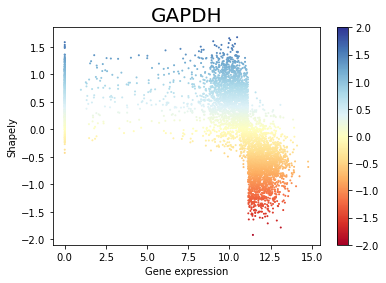

In [431]:
sc = plt.scatter( rna_seq_dataset.cells[:, gene_names.index(gene_name)], 
            shap_values[:, gene_names.index(gene_name)], 
            s=1,
            c=shap_values[:, gene_names.index(gene_name)],
            vmin=-2, vmax=2,
           cmap=plt.cm.get_cmap('RdYlBu'));
plt.colorbar(sc)
plt.title(gene_name);
plt.xlabel('Gene expression');
plt.ylabel('Shapely');

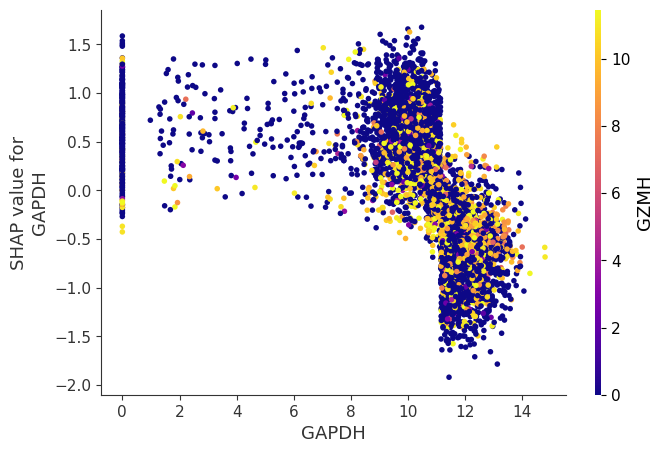

In [432]:
plt.rcdefaults()  # reset params
shap.dependence_plot(gene_names.index('GAPDH'), shap_values, rna_seq_dataset.cells,  feature_names=gene_names, cmap='plasma')


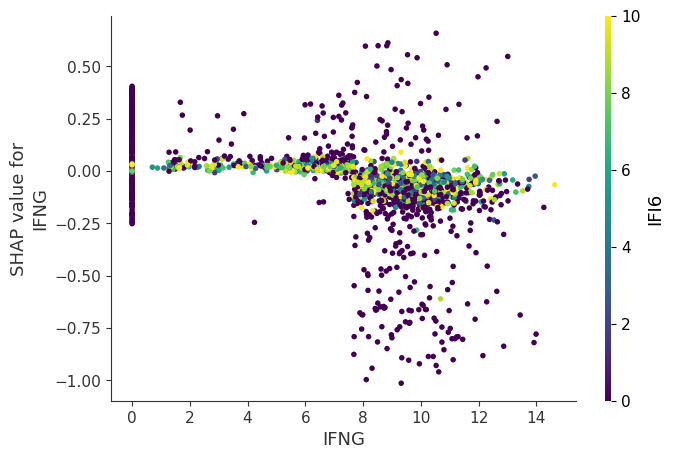

In [95]:
plt.rcdefaults()  # reset params
shap.dependence_plot(gene_names.index('IFNG'), shap_values, rna_seq_dataset.cells,  feature_names=gene_names, cmap='viridis')


In [76]:
n_cells = 5

indices = (np.random.sample(n_cells)*rna_seq_dataset.cells.shape[0]).astype(int)


# shap.force_plot(explainer.expected_value, shap_values[indices], features=rna_seq_dataset.cells[indices], feature_names=gene_names)

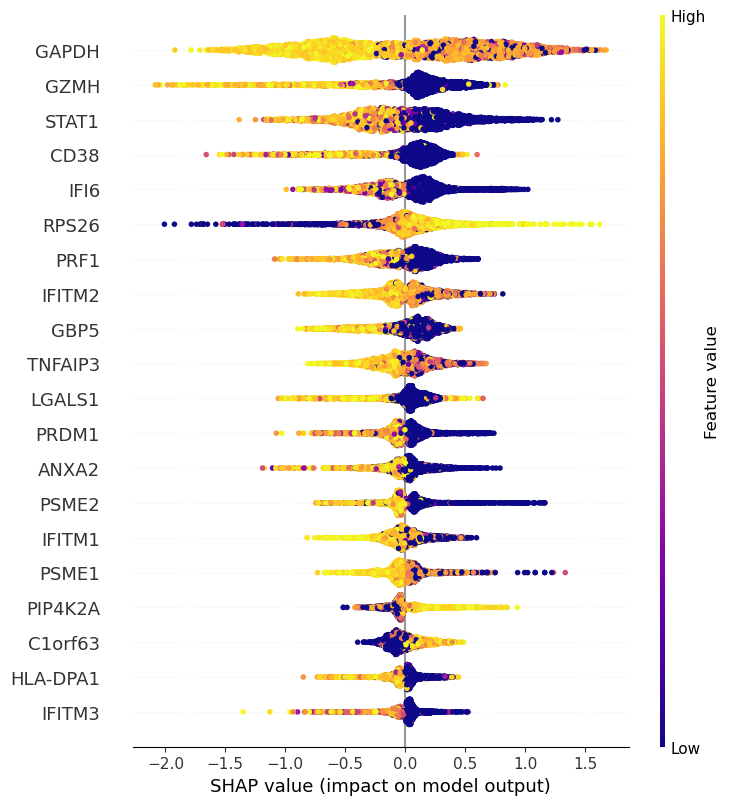

In [434]:
shap.summary_plot(shap_values, features=rna_seq_dataset.cells, feature_names=gene_names, max_display=20, cmap='plasma', show=False)
# plt.savefig(join(VISUALIZATION_OUTPUT, 'top_genes_shap_direction.jpg'), bbox_inches = "tight")

In [421]:
hierarchical_order = get_hierarchical_cells_order(shap_values)


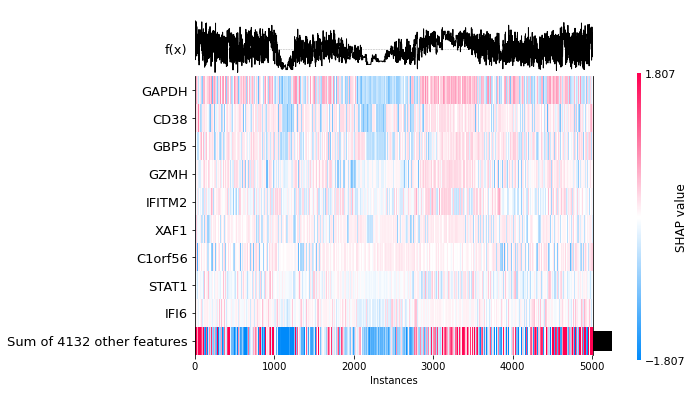

In [422]:
shapely_heatmap(shap_values=shap_values, 
             feature_names=np.array(gene_names), 
             max_display=10,
             instance_order=hierarchical_order,
             cell_values=rna_seq_dataset.cells,
            show=False)
plt.savefig(join(VISUALIZATION_OUTPUT, 'heatmap.jpg'), bbox_inches = "tight")   

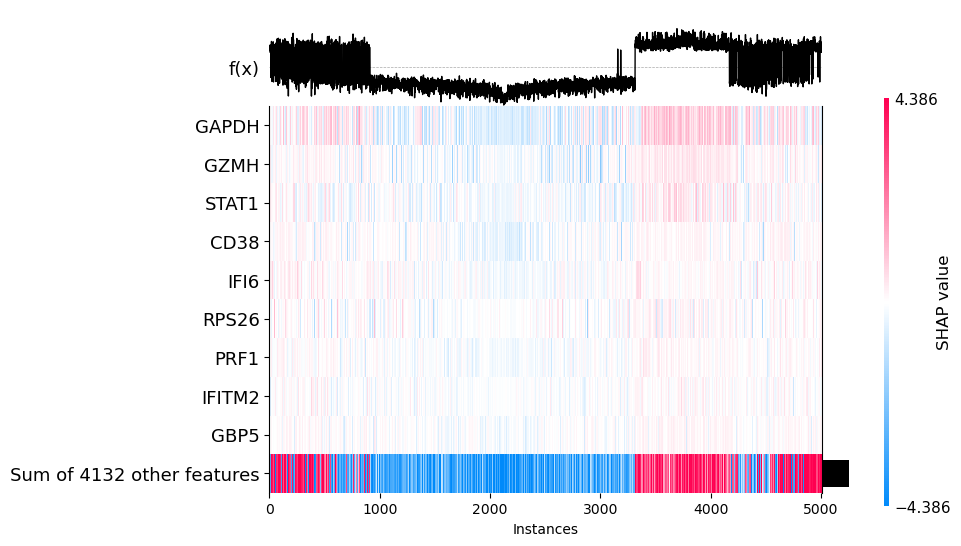

In [124]:
shapely_heatmap(shap_values=shap_values, 
             feature_names=np.array(gene_names), 
             max_display=10,
             instance_order=hierarchical_order,
             cell_values=rna_seq_dataset.cells,
            show=False)
plt.savefig(join(VISUALIZATION_OUTPUT, 'heatmap.jpg'), bbox_inches = "tight")   

In [ ]:
sc = plt.scatter( rna_seq_dataset.cells[:, gene_names.index(gene_name)], 
            shap_values[:, gene_names.index(gene_name)], 
            s=1,
            c=shap_values[:, gene_names.index(gene_name)],
            vmin=-2, vmax=2,
           cmap=plt.cm.get_cmap('RdYlBu'));
plt.colorbar(sc)
plt.title(gene_name);
plt.xlabel('Gene expression');
plt.ylabel('Shapely');

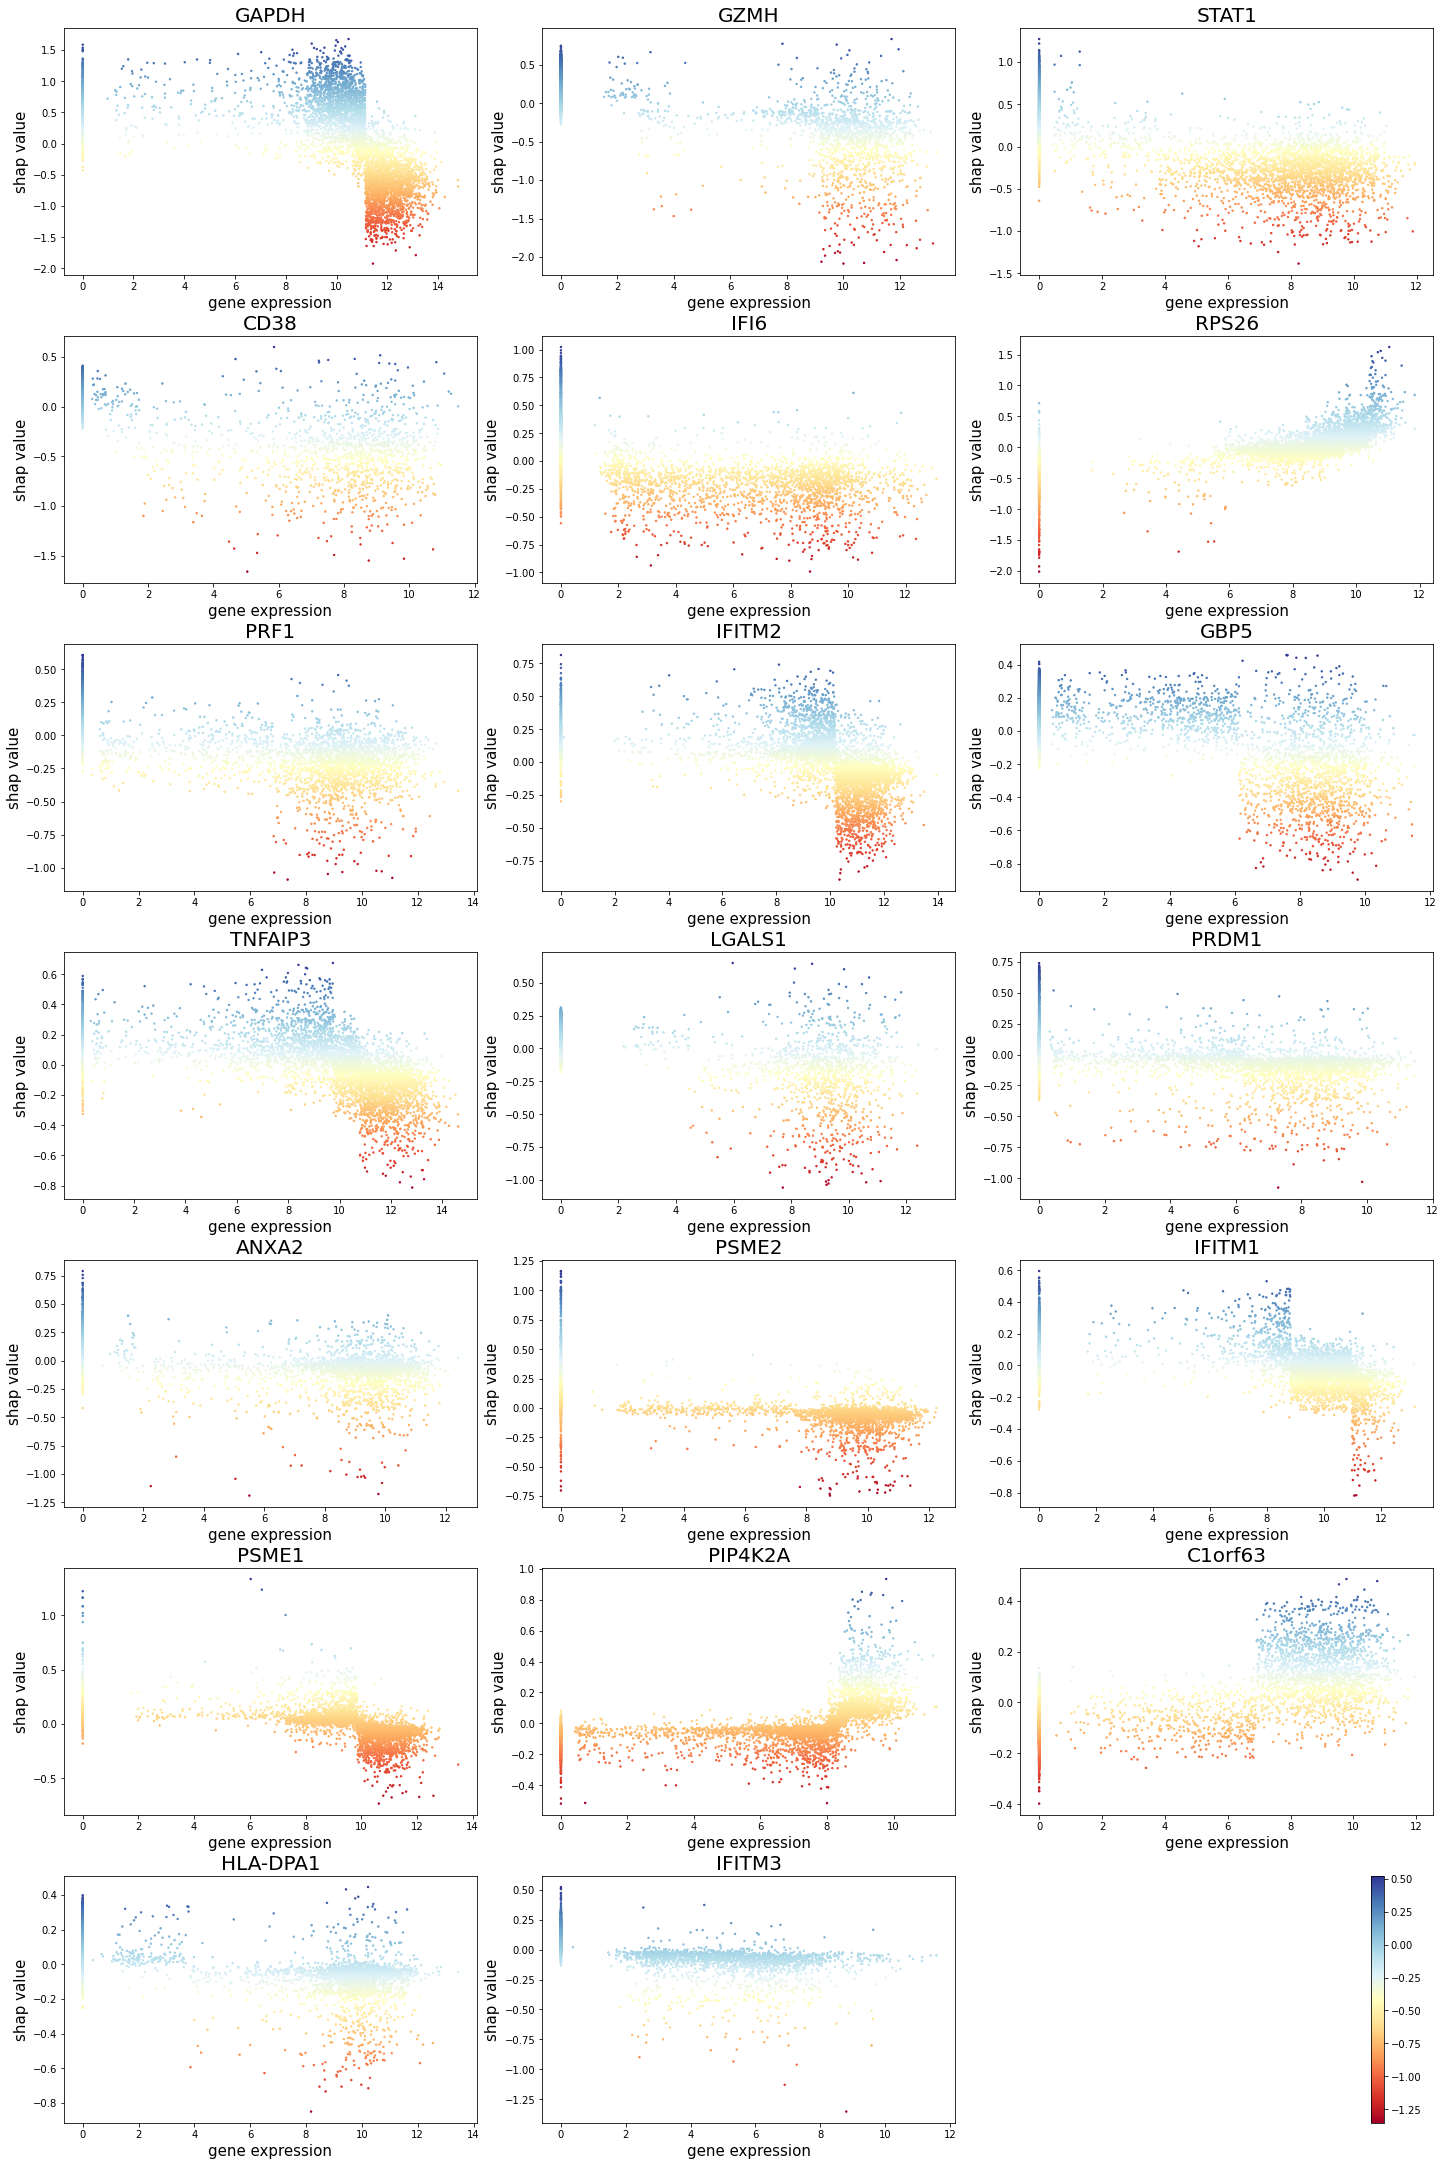

In [325]:
top_k = 20
genes = features_sorted_by_shapely_value[:top_k]




plt.rcdefaults()  # reset params
sns.reset_orig() # reset size of figure

fig, axs = plt.subplots(7, 3)
fig.set_size_inches(20, 30)
axs = axs.ravel()
plt.rcParams['axes.titlesize'] = 20


for ax_idx, gene in enumerate(genes):
    gene_idx = gene_names.index(gene)
    sc = axs[ax_idx].scatter( rna_seq_dataset.cells[:, gene_idx], 
                        shap_values[:, gene_idx], s=2, 
                        c=shap_values[:, gene_idx],
                       cmap=plt.cm.get_cmap('RdYlBu'));
    axs[ax_idx].set(title=gene);
    
    axs[ax_idx].set(xlabel='gene expression');
    axs[ax_idx].set(ylabel='shap value');
    axs[ax_idx].xaxis.label.set_size(15)
    axs[ax_idx].yaxis.label.set_size(15)

plt.colorbar(sc)
plt.tight_layout(pad=0.4)
axs[-1].remove()
fig.savefig(join(VISUALIZATION_OUTPUT, '20_highest_shapely_genes.jpg'), bbox_inches = "tight")   

# DEBUG

In [19]:
from utilities.general_helpers import shapely_heatmap
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy


In [23]:
def get_hierarchical_cells_order(values):
    linked = linkage(values, 'single')
    order = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(linked, values))
    return order






In [477]:
from matplotlib.colors import LinearSegmentedColormap
from shap.plots.colors import red_white_blue



def shapely_heatmap(shap_values, feature_names, instance_order, feature_values, 
            feature_order=None, max_display=10, cmap=red_white_blue, show=True):
    """ Create a heatmap plot of a set of SHAP values.

    This plot is designed to show the population substructure of a dataset using supervised
    clustering and a heatmap. Supervised clustering involves clustering data points not by their original
    feature values but by their explanations. By default we cluster using shap.utils.hclust_ordering
    but any clustering can be used to order the samples.

    Parameters
    ----------
    shap_values : shap.Explanation
        A multi-row Explanation object that we want to visualize in a cluster ordering.
    
    instance_order : OpChain or numpy.ndarray
        A function that returns a sort ordering given a matrix of SHAP values and an axis, or
        a direct sample ordering given as an numpy.ndarray.

    feature_values : OpChain or numpy.ndarray
        A function that returns a global summary value for each input feature, or an array of such values.

    feature_order : None, OpChain, or numpy.ndarray
        A function that returns a sort ordering given a matrix of SHAP values and an axis, or
        a direct input feature ordering given as an numpy.ndarray. If None then we use
        feature_values.argsort
        
    max_display : int
        The maximum number of features to display.

    show : bool
        If show is set to False then we don't call the matplotlib.pyplot.show() function. This allows
        further customization of the plot by the caller after the bar() function is finished. 

    """


    xlabel = "Instances"
    if not feature_order is None:
        values = shap_values[:,feature_order]
        feature_values = feature_values[feature_order]
        feature_names = feature_names[feature_order]
    else:
        values = shap_values
        feature_values = feature_values

    if not instance_order is None:
        values = values[instance_order]
        
        

    # collapse
    if values.shape[1] > max_display:
        new_values = np.zeros((values.shape[0], max_display))
        new_values[:, :max_display-1] = values[:, :max_display-1]
        new_values[:, max_display-1] = values[:, max_display-1:].sum(1)
        new_feature_values = np.zeros(max_display)
        new_feature_values[:max_display-1] = feature_values[:max_display-1]
        new_feature_values[max_display-1] = feature_values[max_display-1:].sum()
        feature_names = list(feature_names[:max_display])
        feature_names[-1] = "Sum of %d other features" % (values.shape[1] - max_display + 1)
        values = new_values
        feature_values = new_feature_values
    
    # define the plot size
    row_height = 0.5
    plt.gcf().set_size_inches(8, values.shape[1] * row_height + 2.5)

    # plot the matrix of SHAP values as a heat map
    vmin = np.nanpercentile(values.flatten(), 1)
    vmax = np.nanpercentile(values.flatten(), 99)
    plt.imshow(
        values.T, aspect=0.7 * values.shape[0]/values.shape[1], interpolation="nearest", vmin=min(vmin,-vmax), vmax=max(-vmin,vmax),
        cmap=cmap
    )
    yticks_pos = np.arange(values.shape[1])
    yticks_labels = feature_names

    plt.yticks([-1.5] + list(yticks_pos), ["f(x)"] + list(yticks_labels), fontsize=13)
    
    plt.ylim(values.shape[1]-0.5, -3)
    
    
    
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.axhline(-1.5, color="#aaaaaa", linestyle="--", linewidth=0.5)
    fx = values.T.mean(0)
    plt.plot(-fx/np.abs(fx).max() - 1.5, color="#000000", linewidth=1)
    #pl.colorbar()
    plt.gca().spines['left'].set_bounds(values.shape[1]-0.5, -0.5)
    plt.gca().spines['right'].set_bounds(values.shape[1]-0.5, -0.5)
    b = plt.barh(
        yticks_pos, (feature_values / np.abs(feature_values).max()) * values.shape[0] / 20, 
        0.7, align='center', color="#000000", left=values.shape[0] * 1.0 - 0.5
        #color=[colors.red_rgb if shap_values[feature_inds[i]] > 0 else colors.blue_rgb for i in range(len(y_pos))]
    )
    for v in b:
        v.set_clip_on(False)
    plt.xlim(-0.5, values.shape[0]-0.5)
    plt.xlabel(xlabel)
    
    
    
    if True:
        import matplotlib.cm as cm
        m = cm.ScalarMappable(cmap=cmap)
        m.set_array([min(vmin,-vmax), max(-vmin,vmax)])
        cb = plt.colorbar(m, ticks=[min(vmin,-vmax), max(-vmin,vmax)], aspect=1000, fraction=0.0090, pad=0.10,
                        panchor=(0,0.05))
        #cb.set_ticklabels([min(vmin,-vmax), max(-vmin,vmax)])
        cb.set_label("SHAP value", size=12, labelpad=-10)
        cb.ax.tick_params(labelsize=11, length=0)
        cb.set_alpha(1)
        cb.outline.set_visible(False)
        bbox = cb.ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
        cb.ax.set_aspect((bbox.height - 0.9) * 15)
        cb.ax.set_anchor((1,0.2))
        #cb.draw_all()
        
    for i in [0]:
        plt.gca().get_yticklines()[i].set_visible(False)
    
    if show:
        plt.show()

In [244]:
n_cells = 1000
x = shap_values[:n_cells]
hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(hierarchy.ward(X), X))
# hierarchy.ward(X)
hierarchy.optimal_leaf_ordering(hierarchy.ward(X), X)
# hierarchy.leaves_list(hierarchy.ward(X))

array([[ 9.        ,  5.        ,  2.10442479,  2.        ],
       [10.        ,  8.        ,  2.44005854,  3.        ],
       [ 1.        , 11.        ,  2.9784393 ,  4.        ],
       [ 6.        ,  2.        ,  3.20995188,  2.        ],
       [ 4.        , 12.        ,  4.19605191,  5.        ],
       [13.        ,  3.        ,  4.47343217,  3.        ],
       [ 0.        , 15.        ,  4.84570632,  4.        ],
       [14.        ,  7.        ,  4.93182019,  6.        ],
       [16.        , 17.        ,  7.7742521 , 10.        ]])

In [203]:
rng = np.random.default_rng()
X = rng.standard_normal((10, 10))
Z = hierarchy.ward(X)
hierarchy.leaves_list(Z)
np.array([0, 3, 1, 9, 2, 5, 7, 4, 6, 8])
hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, X))
np.array([3, 0, 2, 5, 7, 4, 8, 6, 9, 1])

array([3, 0, 2, 5, 7, 4, 8, 6, 9, 1])

In [261]:

n_cells = 20
x = shap_values[:n_cells]

linked = linkage(x, 'single')
# linked

In [264]:
values = shap_values[:n_cells]
linked = linkage(values, 'single')
order = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(linked, x))

In [265]:
order

array([476, 350, 203, 303, 327, 441, 241, 309, 396, 512,  16, 418, 460,
       931, 381, 372, 482, 267, 507, 386,   3,  43, 284, 472, 359, 341,
       316, 468, 419, 355, 288, 509, 988, 860, 817, 805, 786, 758, 665,
       627, 570, 492, 448, 443, 411, 388, 335, 313, 208,  74,  44,  15,
        11,   9,  26,  66, 125, 218, 330, 377, 394, 413, 445, 463, 544,
       574, 660, 756, 760, 801, 810, 850, 863, 949, 872, 832, 741, 680,
       639, 600, 576, 553, 424, 343, 333, 266, 200,  53,  17,  24,  51,
       189, 226, 276, 338, 370, 551, 571, 592, 623, 674, 681, 762, 837,
       917, 985, 984, 855, 806, 751, 618, 588, 562, 554, 206,   5, 119,
       186, 302, 555, 579, 607, 686, 767, 841, 955,  73, 584, 368,  29,
       622, 444, 291, 191, 131,  37,  92, 101, 135, 270, 440, 609, 635,
       793, 690, 591, 545, 148,  61,   1,  19,  33, 117, 207, 561, 668,
       712, 947, 912, 873, 847, 804, 729, 715, 662, 590, 575, 426, 398,
       389, 329, 311, 224, 184, 134, 133, 209, 238, 326, 380, 39